# Processing statistics from probe files

In [1]:
%%capture

# Change some display properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Important header information

# Import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt

naluhelperdir = '../utilities'
sys.path.insert(1, naluhelperdir)
import windspectra
#import yaml as yaml
#from IPython.display import Image
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
# Probe file locations
datadir='./probeData/'
probefiles=[
    'l_h1_0.dat',
    'l_h2_1.dat',
    'l_h3_2.dat',
    'l_h4_3.dat',
    'l_h5_4.dat',
    'l_h6_5.dat',
    'l_h7_6.dat',
    'l_h8_7.dat',
    'l_h9_8.dat',
    'l_v2_9.dat',
    'l_v3_10.dat',
    'l_v4_11.dat',
    'l_v5_12.dat',
    'l_v6_13.dat',
    'l_v7_14.dat',
    'l_v8_15.dat',
    'l_v9_16.dat',
]


In [3]:
avgbins    = [[50,600]] 
deltaX     = 2.5
xlocations = [-160, -120, -80, -40, 0, 40, 80, 120, 160 ]

In [4]:
# Define some dicts to save stuff
Suu_avg={}
Svv_avg={}
Sww_avg={}
avgUlong={}
zavg={}
favg={}
Su_Kai={}
Sv_Kai={}
Sw_Kai={}

In [5]:
# Extract the spectra
for x in xlocations:
    print('x = %f'%x)
    favg[x], Suu_avg[x], Svv_avg[x], Sww_avg[x], avgUlong[x]=windspectra.avgSpectraFiles(probefiles, None, datadir=datadir,
                                                                                         verbose=False,    avgbins=avgbins, 
                                                                                         selectfunc=lambda d: d[d[:,1]==x,:])

x = -160.000000
x = -120.000000
x = -80.000000
x = -40.000000
x = 0.000000
x = 40.000000
x = 80.000000
x = 120.000000
x = 160.000000


array([ 160.,  140.,  120.,  100.,   80.,   60.,   40.,   20.,    0.,
        -20.,  -40.,  -60.,  -80., -100., -120., -140., -160.])

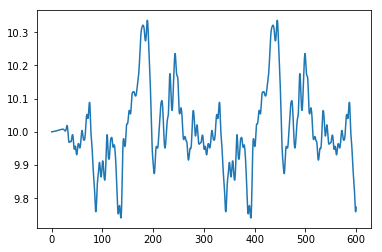

In [6]:
# Test data input sizes
dat=np.loadtxt(datadir+'/'+probefiles[0], skiprows=1)
subview = lambda x: x[x[:,1]==120,:]
x=subview(dat)
plt.plot(x[:,0],x[:,4])
dat[dat[:,0]==0.25,1]

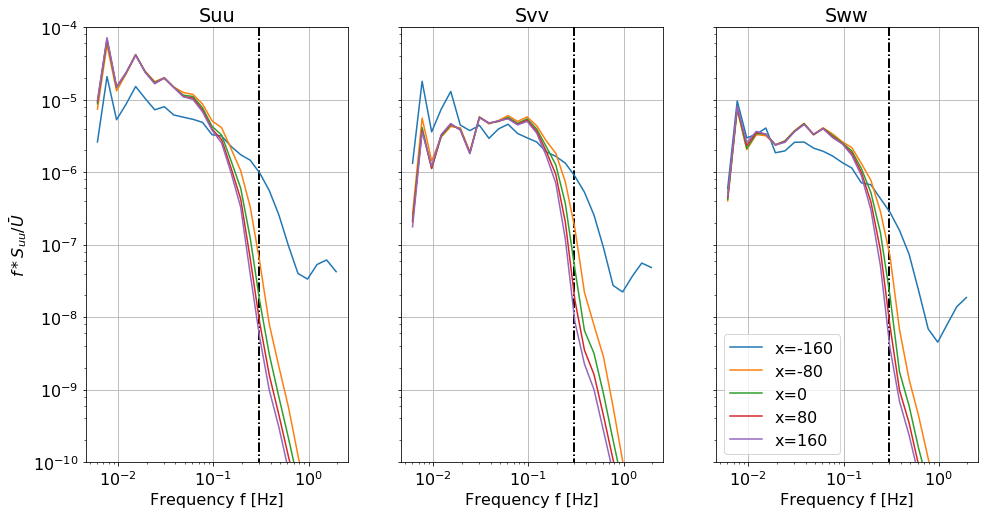

In [7]:
Nband = 3
#plotxlocs=[-160, -120, -80, 0, 80,120, 160]
plt.rc('font', size=16)
fig, axs = plt.subplots(1,3,figsize=(16,8),sharey=True)
for x in xlocations[::2]:
    avgf, avgSuu = windspectra.NarrowToOctaveBand(favg[x], Suu_avg[x], Nband)
    avgf, avgSvv = windspectra.NarrowToOctaveBand(favg[x], Svv_avg[x], Nband)
    avgf, avgSww = windspectra.NarrowToOctaveBand(favg[x], Sww_avg[x], Nband)
    fmax = 0.6*avgUlong[x]/(8*deltaX)
    #print('avgU = %e'%avgUlong[x])
    axs[0].loglog(avgf, avgf*avgSuu/avgUlong[x]**2, label='x=%i'%x)
    axs[1].loglog(avgf, avgf*avgSvv/avgUlong[x]**2, label='x=%i'%x)
    axs[2].loglog(avgf, avgf*avgSww/avgUlong[x]**2, label='x=%i'%x)

axs[0].set_ylabel(r'$f*S_{uu}/\bar{U}$')
axs[0].set_title('Suu')
axs[1].set_title('Svv')
axs[2].set_title('Sww')
    
plt.legend(loc='lower left')
plt.ylim([1E-10, 1E-4])
for i in range(3): 
    axs[i].vlines(fmax, 5e-11, 20,lw=2, linestyle='-.')
    axs[i].set_xlabel('Frequency f [Hz]')
    axs[i].grid()